In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
from scipy.optimize import curve_fit
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [12]:
def NGD2L_TK_AS(T, epsilon, gamma, omegastar, deltastar, tau_y, Dmp):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    Kw = -Dmp*( 1/np.cos(deltastar)*np.exp(-epsilon*T)*np.cos(T*omegastar+deltastar) -np.exp(-gamma*T) )
    w = np.convolve(x, Kw, 'full')[:len(T):50]*dt
    return w/(dt)

In [13]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

In [14]:
dt = 0.01
cn = 34

file_list = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20210720\\WF\\data\\diode_WhiteNoise_mean=10_amp=0.5_20-Jul-2021_0',
             'D:\\GoogleDrive\\retina\\Chou\'s data\\20210720\\WF\\data\\diode_WhiteNoise_mean=10_amp=1_20-Jul-2021_0',
             'D:\\GoogleDrive\\retina\\Chou\'s data\\20210720\\WF\\data\\diode_WhiteNoise_mean=10_amp=1.5_20-Jul-2021_0',
             'D:\\GoogleDrive\\retina\\Chou\'s data\\20210720\\WF\\data\\diode_WhiteNoise_mean=10_amp=2_20-Jul-2021_0',
             'D:\\GoogleDrive\\retina\\Chou\'s data\\20210720\\WF\\data\\diode_WhiteNoise_mean=10_amp=3_20-Jul-2021_0']
contrast_list = [5, 10, 15, 20, 30]
x_list = []
T_list = []
rstate_list = []
for file in file_list:
    annots = loadmat(file, squeeze_me = True)
    sampling_rate = 20000
    TimeStamps = annots['TimeStamps']
    x = annots['a_data'][0, int(TimeStamps[0]*sampling_rate):int(TimeStamps[1]*sampling_rate)+1]
    x = ndimage.gaussian_filter1d(x, sigma=int(sampling_rate*dt/5), mode='reflect') / dt
    x = x[::int(sampling_rate*dt)]
    x = x.astype(float)
    print(np.std(x)/4E4)
    # x = (x -np.mean(x))/np.std(x)
    T = np.arange(len(x)+1)*dt
    rstate,_ = np.histogram(annots['Spikes'][cn-1]-TimeStamps[0], T)
    rstate_list.append( rstate.copy() )
    x_list.append( x.copy() )
    T_list.append( T.copy() )

0.49115740987722317
0.9872355963536171
1.4731203982414158
1.962898533370301
2.934936120653217


(0.0, 1.0)

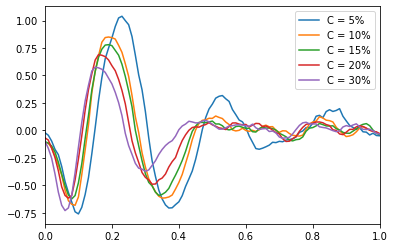

In [15]:
TKaxis = np.arange(101)*dt
TK_list = []
for i in range(len(x_list)):
    rstate = rstate_list[i]
    x = x_list[i]
    x = (x -np.mean(x))/np.std(x)
    TK = np.correlate(x , rstate, 'same')/ np.correlate(np.ones_like(x), rstate, 'same')
    TK = TK[int(len(TK)/2):int(len(TK)/2-1/dt)-1:-1]
    plt.plot(TKaxis, TK, label = 'C = '+str(contrast_list[i])+'%')
    TK_list.append( TK.copy() )
plt.legend(loc = 'best')
plt.xlim(0, 1)

Text(0.5, 1.0, 'group delay')

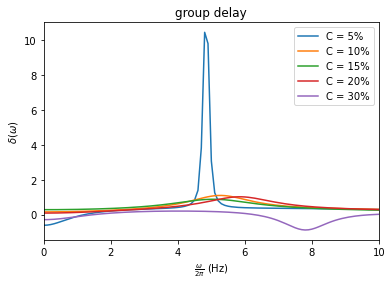

In [16]:
df = 0.1
faxis = np.arange(-20,20,df)
for i in range(len(x_list)):
    F_TK = np.sum(TK_list[i][np.newaxis,:]*np.exp(-1j*TKaxis[np.newaxis,:]*faxis[:,np.newaxis]), axis = 1)*dt
    Phi = np.angle(F_TK)
    delta = -angular_gradient(Phi)/df
    plt.plot(faxis, delta, label = 'C = '+str(contrast_list[i])+'%')
plt.legend(loc = 'best')
plt.ylabel(r'$\delta(\omega)$')
plt.xlabel(r'$\frac{\omega}{2\pi}$ (Hz)')
plt.xlim([0,10])
plt.title('group delay')

(0.0, 1.0)

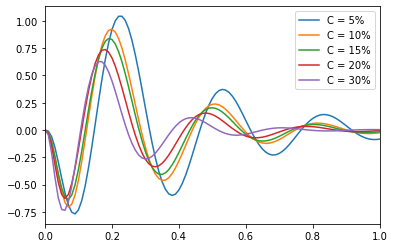

In [17]:
name_list = ['epsilon', 'gamma', 'omegastar', 'deltastar', 'tau_y', 'Dmp']
para_2dlist = []
fitTK_list = []
for i in range(len(x_list)):
    epsilon = 10. #1/sec
    gamma = 25.
    omegastar = 30. 
    deltastar = 0.
    tau_y = 0.04
    Dmp = 10.
    popt,_ = curve_fit(NGD2L_TK_AS, TKaxis , TK_list[i], 
                        p0     =  [epsilon, gamma , omegastar, deltastar, tau_y, Dmp   ],
                        bounds = ([0      , 0     , 0        , -np.pi/2 , 0    , 0     ], 
                                  [np.inf , np.inf, np.inf   ,  np.pi/2 , 0.1  , np.inf ] ))
    fitTK = NGD2L_TK_AS(TKaxis, *popt)
    plt.plot(TKaxis, fitTK, label = 'C = '+str(contrast_list[i])+'%')
    fitTK_list.append( fitTK.copy() )
    para_2dlist.append( popt.copy() )
plt.legend(loc = 'best')
plt.xlim(0, 1)

Text(0.5, 1.0, 'group delay')

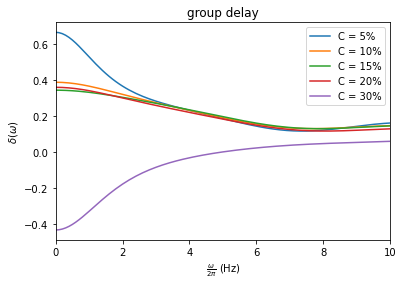

In [18]:
df = 0.1
faxis = np.arange(-20,20,df)
for i in range(len(x_list)):
    F_TK = np.sum(fitTK_list[i][np.newaxis,:]*np.exp(-1j*TKaxis[np.newaxis,:]*faxis[:,np.newaxis]), axis = 1)*dt
    Phi = np.angle(F_TK)
    delta = -angular_gradient(Phi)/df
    plt.plot(faxis, delta, label = 'C = '+str(contrast_list[i])+'%')
plt.legend(loc = 'best')
plt.ylabel(r'$\delta(\omega)$')
plt.xlabel(r'$\frac{\omega}{2\pi}$ (Hz)')
plt.xlim([0,10])
plt.title('group delay')

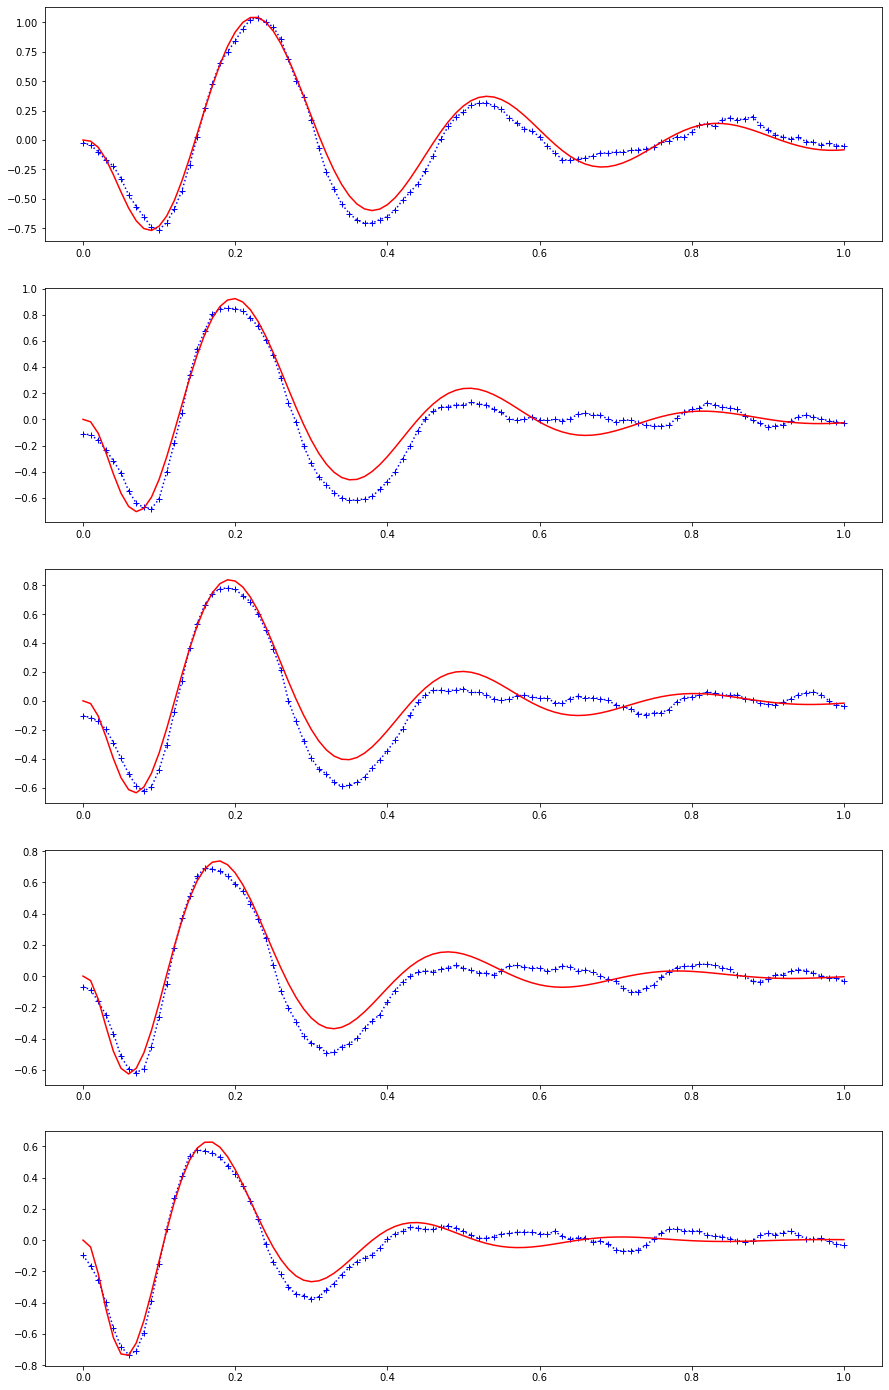

In [19]:
fig, ax = plt.subplots(len(x_list),1)
for i in range(len(x_list)):
    ax[i].plot(TKaxis, TK_list[i], 'b+:')
    ax[i].plot(TKaxis, fitTK_list[i], 'r-')
    # ax[i][1].plot(faxis, delta)
fig.set_size_inches( 15, 5*len(x_list) )

In [20]:
pd.DataFrame(para_2dlist, index = contrast_list, columns = name_list)

,epsilon,gamma,omegastar,deltastar,tau_y,Dmp
5,3.187638,29.638555,20.786974,-0.434566,0.033733,2.386966
10,4.327950,41.654863,20.457614,-0.151923,0.024010,2.255261
15,4.575971,43.446836,20.653502,-0.113519,0.023016,2.081389
20,5.150161,54.476711,20.862602,-0.017971,0.018355,1.823985
30,6.338261,63.902637,23.178842,-0.197677,0.015641,1.717487
